# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [223]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [224]:
df_train.info()
df_test.info()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Для корректного рассчета MAE необходимо избавиться от бесконечных значений, 0 и пропусков.

In [225]:
def recovery(C, F, T):
    value = (((C * (F - T))) / (F * (C - T))) * 100
    value[value<0] = np.nan
    value[value>100] = np.nan
    return value

In [226]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
input_recovery = df_train['rougher.output.recovery']
mean_absolute_error(input_recovery.fillna(method='ffill'), recovery(C, F, T).fillna(method='ffill'))

9.514308413213554e-15

MAE между нашими расчетами и значением признака близка к 0, эффективность обогащения рассчитана правильно.

In [227]:
df_train_columns = df_train.columns
df_test_columns = df_test.columns
dif_columns = df_train_columns[~df_train_columns.isin(df_test_columns)]

dif_columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

In [228]:
df_train.duplicated().sum()
df_test.duplicated().sum()
df_full.duplicated().sum()

0

0

0

In [229]:
df_full = df_full.dropna(axis='index', how='any', subset=['rougher.output.recovery', 'final.output.recovery'])
df_train = df_train.dropna(axis='index', how='any', subset=['rougher.output.recovery', 'final.output.recovery'])

In [230]:
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)
df_full.fillna(method='ffill', inplace=True)

df_train.isna().sum()
df_test.isna().sum()
df_full.isna().sum()


date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

# 2. Анализ данных 

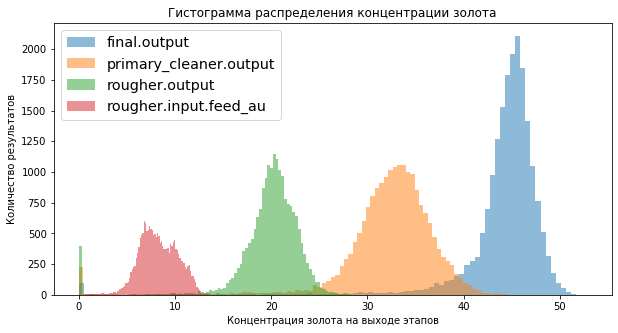

In [231]:
plt.figure(figsize=[10,5])

plt.hist(df_full['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(df_full['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(df_full['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)
plt.hist(df_full['rougher.input.feed_au'], bins=100, label = 'rougher.input.feed_au', alpha=.5)

plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='best', fontsize='x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show();

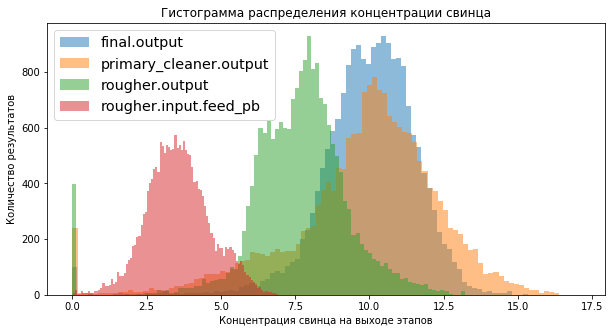

In [232]:
plt.figure(figsize=[10,5])

plt.hist(df_full['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(df_full['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(df_full['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)
plt.hist(df_full['rougher.input.feed_pb'], bins=100, label = 'rougher.input.feed_pb', alpha=.5)

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='best', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show();

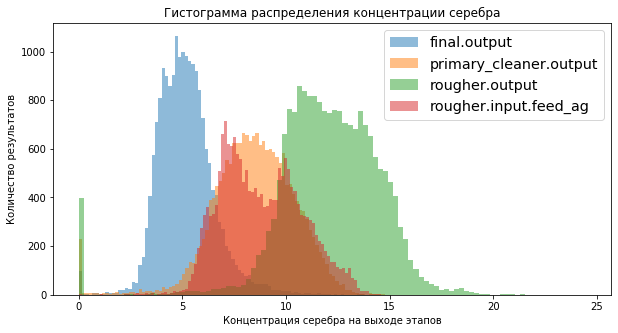

In [233]:
plt.figure(figsize=[10,5])

plt.hist(df_full['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(df_full['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(df_full['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)
plt.hist(df_full['rougher.input.feed_ag'], bins=100, label = 'rougher.input.feed_ag', alpha=.5)

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='best', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show();

Отмечаем рост концентрации золота на каждом этапе и уменьшение концентрации серебра.Расперделение стало более концентрированным вокруг среднего по всем металлам - значениям можно доверять.

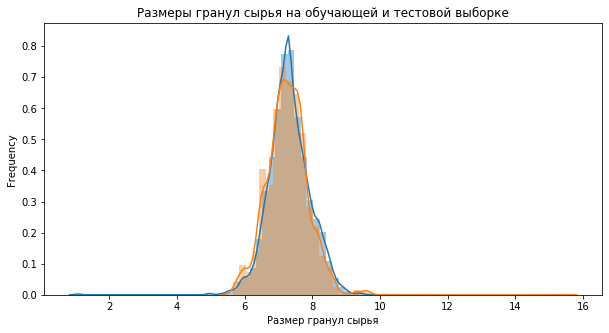

In [234]:
plt.figure(figsize=(10,5))
sns.distplot(df_train['primary_cleaner.input.feed_size'],label='train primary_cleaner.input.feed_size')
sns.distplot(df_test['primary_cleaner.input.feed_size'],label='test primary_cleaner.input.feed_size')
plt.title('Размеры гранул сырья на обучающей и тестовой выборке')
plt.legend
plt.xlabel('Размер гранул сырья')
plt.ylabel('Frequency');

In [235]:
train_feed_size = df_train['primary_cleaner.input.feed_size']
test_feed_size = df_test['primary_cleaner.input.feed_size']
alpha = .05
results = st.ttest_ind(train_feed_size, test_feed_size)
if (results.pvalue < alpha):
    print("Распределения размеров гранул в двух выборках не отличаются")
else:
    print("Распределения размеров гранул в двух выборках отличаются")

Распределения размеров гранул в двух выборках не отличаются


In [236]:
def all_metal(train, test):
    fig, axes = plt.subplots(1, 4, figsize=(18,7)) 
    fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=18)
    summary_train_concentration = []
    summary_test_concentration = []
    for stage, ax in zip(stages, axes):
        ax.set_title(stage)
        summary_train_concentration = train[stage+metals[0]] + train[stage+metals[1]] + train[stage+metals[2]]
        if stage==stages[0]:
            summary_test_concentration = test[stage+metals[0]] + test[stage+metals[1]] + test[stage+metals[2]]
            sns.distplot(summary_test_concentration, ax=ax) 
        sns.distplot(summary_train_concentration, ax=ax)
    plt.show()

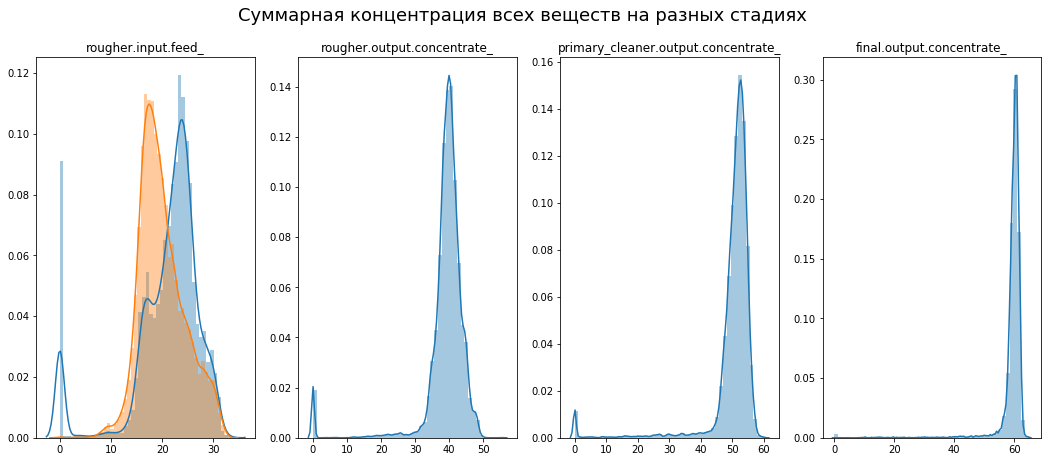

In [237]:
all_metal(df_train, df_test)

In [238]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

df_full['сырье'] = df_full[[first+'au', first+'ag', first+'pb']].sum(axis=1)
df_full['черновой концентрат'] = df_full[[second+'au', second+'ag', second+'pb']].sum(axis=1)
df_full['концентрат после очистки'] = df_full[[third+'au', third+'ag', third+'pb']].sum(axis=1)
df_full['финальный концентрат'] = df_full[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [239]:
df_full = df_full[
    (df_full['сырье'] >  1) & 
    (df_full['черновой концентрат'] > 1) & 
    (df_full['концентрат после очистки'] > 1) & 
    (df_full['финальный концентрат'] > 1)
]

In [240]:
df_train = df_train[df_train['date'].isin(df_full['date'])]
df_test = df_test[df_test['date'].isin(df_full['date'])]
df_train.dropna(inplace=True) 
df_test.dropna(inplace=True)

In [241]:
df_train.shape, df_test.shape

((13598, 87), (5123, 53))

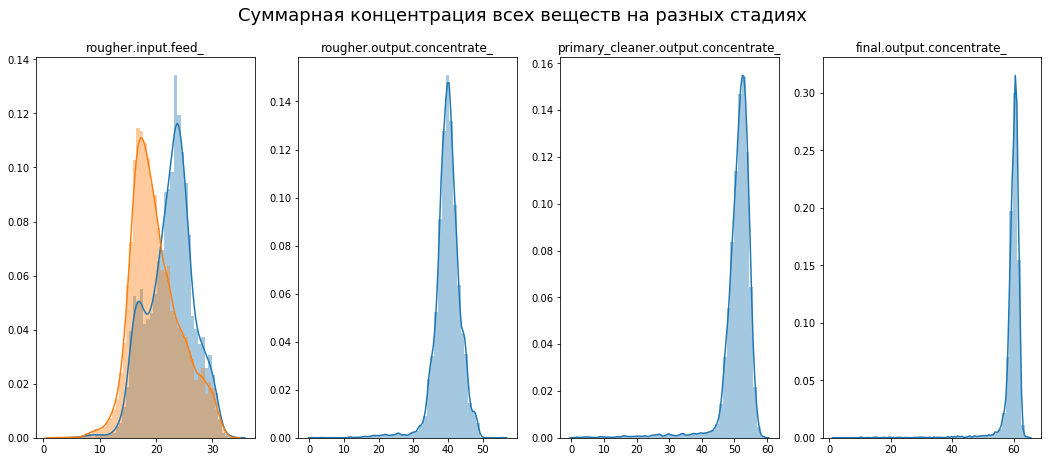

In [242]:
all_metal(df_train, df_test)

После удаления предположительно ошибочных нулевых значений, близкие к нулю значения остались,но удалять их я не считаю корректным - возможно искажение результата.

# 3. Модель

Индексируем данные по столбцу данных

In [243]:
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train = df_train.drop(['date'], axis=1)

df_test.index = pd.DatetimeIndex(df_test['date'])
df_test = df_test.drop(['date'], axis=1)

df_full.index = pd.DatetimeIndex(df_full['date'])
df_full = df_full.drop(['date'], axis=1)

Создадим наборы обучающей и тестовой выборки для предсказания rougher.output.recovery.
Для обучающей и тестовой выборки выберем все признаки содержащие rougher в df_tes

In [244]:
rougher_columns = df_test.loc[:, df_test.columns.str.contains('rougher')].columns

X_train_rougher = df_train[rougher_columns]
y_train_rougher = df_train[['rougher.output.recovery']]

X_test_rougher = df_test[rougher_columns]
y_test_rougher = df_full[['rougher.output.recovery']].query('index in @df_test.index')

Создадим наборы обучающей и тестовой выборки для предсказания final.output.recovery.
Для обучающей и тестовой выборки выберем все признаки кроме final.output

In [245]:
final_columns = df_full.loc[:, ~df_full.columns.str.contains('final.output')].columns

X_train_final = df_full[final_columns].query('index in @df_train.index')
y_train_final = df_train[['final.output.recovery']]

X_test_final = df_full[final_columns].query('index in @df_test.index')
y_test_final = df_full[['final.output.recovery']].query('index in @df_test.index')

In [246]:
def smape(y_true, y_predict):
    numerator = abs(y_true - y_predict)
    denominator = (abs(y_true) + abs(y_predict)) / 2
    summa = (numerator / denominator).sum()

    smape = 1 / len(y_true) * summa * 100
    return smape


In [247]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('model', MultiOutputRegressor(LinearRegression()))])
param_grid = [{'model': [MultiOutputRegressor(LinearRegression())]}, 
               {'model': [MultiOutputRegressor(Ridge())]}, 
               {'model': [MultiOutputRegressor(Lasso())]}, 
               {'model': [MultiOutputRegressor(SGDRegressor())]}, 
               {'model': [MultiOutputRegressor(SVR(kernel='poly'))]}, 
               {'model': [MultiOutputRegressor(LinearSVR())]}, 
               {'model': [MultiOutputRegressor(RandomForestRegressor())]}, 
               {'model': [MultiOutputRegressor(XGBRegressor(objective ='reg:squarederror'))]}]

In [248]:
kfold = KFold(n_splits=3)

In [249]:
smape_score = make_scorer(smape, greater_is_better=False)

Модель для rougher

In [250]:
grid_model_rougher = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1, scoring=smape_score)

Модель для final

In [251]:
grid_model_final = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1, scoring=smape_score)

Обучим модель для этапа rougher

In [252]:
grid_model_rougher.fit(X_train_rougher, y_train_rougher);

In [253]:
grid_model_rougher.best_params_

{'model': MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators='warn',
                                                      n_jobs=None,
                                                      oob_score=False,
                        

Подобрали лучшую модель

In [254]:
y_pred_array_rougher = pd.DataFrame(grid_model_rougher.predict(X_test_rougher))

In [255]:
y_pred_array_rougher = y_pred_array_rougher[0]
y_true_rougher = y_test_rougher.reset_index()
y_true_rougher = y_true_rougher.drop('date', axis=1)['rougher.output.recovery']

In [256]:
smape_rougher = smape(y_true_rougher, y_pred_array_rougher)
print('Метрика после rougher:{}'.format(smape_rougher))

Метрика после rougher:4.997478377359058


Проделываем те же операции для модели final

In [257]:
grid_model_final.fit(X_train_final, y_train_final);

In [258]:
grid_model_final.best_params_

{'model': MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators='warn',
                                                      n_jobs=None,
                                                      oob_score=False,
                        

Подобрали лучшую модель

In [259]:
y_pred_array_final = pd.DataFrame(grid_model_final.predict(X_test_final))

In [260]:
y_pred_array_final = y_pred_array_final[0]
y_true_final = y_test_final.reset_index()
y_true_final = y_true_final.drop('date', axis=1)['final.output.recovery']

In [261]:
smape_final = smape(y_true_final, y_pred_array_final)
print('Метрика после final:{}'.format(smape_final))

Метрика после final:6.386156717171636


In [262]:
smape_total = 0.25 * smape_rougher + 0.75 * smape_final
print("Итоговая метрика качества модели: {}".format(smape_total))

Итоговая метрика качества модели: 6.038987132218491


Цель проекта - подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды достигнута.

Во время проекта были выполнены следующие шаги:
прочитали и изучили данные
 
провели предобработку данных (обработка пропусков, проверка на дубликаты)
удалили строки, в которых есть пропуски в целевых колонка.
убедились, что эффективность обогащения рассчитана правильно.

проверили, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Можем сделать вывод, что концентрация каждого из металлов меняется в зависимости от этапа очистки: концентрация золота постепенно увеличивается с каждым этапом, серебра — падает, а свинца растёт на первых 3-х этапах.
провели анализ размера гранул на обучающей и тестовой выборках и убедились, что размеры гранул не отличаются.
провели анализ суммарной концентрации всех металлов на разных стадиях, обнаружили и удалили аномалии из всех датасетов.

написали функции для расчёта sMAPE и итоговой sMAPE
с помощью GridSearchCV на основе нашей метрики подобрали параметры.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке